In [1]:
# Initiate game
# generate n_players suits where n_players is currently 5
# generate n_cards per suit
# shuffle cards


# Player
# Once the trade is executed, register the trade on their own ledger
## information recorded
# Functionalities reveal private information
# Compute private and perceived probabilities
# generate insights
# plot risks


# MarketMakers
# ability to set bid and ask price
# arbitage alert


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# utilities lib
from utils import shuffle, generate_cards, distribute, \
mergePrivateAndPublic, calculateProbability, executeTrade

# Classes
TODO: complete avg mid price visualisations

In [25]:
class PublicBoard:
    suits = ['S', 'H', 'C', 'D']
    n_cards_per_suit = 13
    def __init__(self):
        self.revealedCards = []
        self.bidAsk = dict(zip(suits, [[] for _ in range(len(suits))]))
        self.bidAskInfo = pd.DataFrame(columns=['Action']+suits)
        d = {}
        for key in ['Public Prob ' + str(suit) for suit in suits]:
            d[key] = [1.0]
        self.publicInformation = pd.DataFrame.from_dict(d, orient='columns')
    
    def updateProbability(self, idx):
        # update public probability
        self.publicInformation.loc[idx] = calculateProbability(self.revealedCards, n_cards_per_suit, suits)
    
    def revealedFromPublicDeck(self, deck):
        revealedCard = deck.pop()
        self.revealedCards.append(revealedCard)
        return revealedCard
    
    def updateBidAsk(self, suit, bidAskPrice, action, trade, idx):
        self.bidAsk[suit].append(bidAskPrice)
        [self.bidAsk[s].append([None, None]) for s in suits if s != suit]
        self.bidAskInfo.loc[idx] = [float(str(action)+'.'+str(trade))] + [self.bidAsk[key][idx-1] for key in suits]
    
    def viz(self):
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
        axes = axes.flat
        temp = self.bidAskInfo.copy()
        temp['Action'] = temp.agg({'Action':np.floor})
        for s in suits:
            temp[s+' Mid Value'] = temp[s].apply(lambda x: 0.5*(x[0]+x[1]) if None not in x else None)
            temp.groupby('Action')[s+' Mid Value'].mean().interpolate().plot(label=s+' Avg. Mid Price', ax=axes[1], marker='x')

        self.publicInformation.plot(ax=axes[0], marker='x')
        axes[0].set_ylim(-0.1, 1.1)
        axes[0].set_xlim(0, temp['Action'].max()+1)
        axes[0].set_title('Perceived Information (Risk)')
        axes[0].legend()
        axes[1].set_xlim(0, temp['Action'].max())
        axes[1].set_title('Avg. Mid Price Per Action')
        axes[1].legend()
        
        plt.tight_layout()
        
        

In [26]:
# temp = pb.bidAskInfo.copy()
# temp['Action'] = temp.agg({'Action':np.floor})
# for s in suits:
#     if s not in [p1.name, p2.name]:
#         # since we are only testing with p1 and p2
#         break
#     temp[s+' Mid Value'] = temp[s].apply(lambda x: 0.5*(x[0]+x[1]) if None not in x else None)
#     temp.groupby('Action')[s+' Mid Value'].mean().plot(label=s+' Avg. Mid Price')
# plt.legend()
# plt.show()


In [27]:
# player includes market makers and speculator
class Player:
    suits = ['S', 'H', 'C', 'D']
    n_cards_per_suit = 13
    def __init__(self, privateCards, name):
        self.name = name
        self.privateCards = privateCards
        
        self.ledger = pd.DataFrame(columns=['Action', 'CounterParty', 'Contract', 'Price', 'Quantity', 'Buy/Sell']+\
                                   suits+['Cash'])
        self.inventories = {'S':0, 'H':0, 'C':0, 'D':0}
        self.cash = 0

        
        d = {}
        for key in ['Private Prob ' + str(suit) for suit in suits]:
            d[key] = [1.0]
        self.privateInformation = pd.DataFrame.from_dict(d, orient='columns')
        
    def updateProbability(self, idx, revealedCards):
        # update private probability
        self.privateInformation.loc[idx] = calculateProbability(\
                                            mergePrivateAndPublic(self.privateCards, revealedCards), n_cards_per_suit, suits)
    
    def revealPrivateCard(self, cardToBeRevealed):
        if cardToBeRevealed in self.privateCards:
            idx = self.privateCards.index(cardToBeRevealed)
            cardRevealed = self.privateCards.pop(idx)
            return cardRevealed
        raise Exception("Card not in private deck.")
        
#     bid is higher than ask, [bid, ask]
    def buy(self, counterParty, bidAskPrice, contract, numContracts, idx, action, trade):
        self.inventories[contract] += numContracts 
        tradeNum = float(str(action) +'.'+str(trade))
        if contract == self.name:
            self.cash -= numContracts*bidAskPrice[1]
            entry = [tradeNum, counterParty.name, contract, -1*bidAskPrice[1], numContracts, 'Buy'] + \
                                   [self.inventories[key] for key in suits] + \
                                   [self.cash]
        else:
            self.cash -= numContracts*bidAskPrice[0]
            entry = [tradeNum, counterParty.name, contract, -1*bidAskPrice[0], numContracts, 'Buy'] + \
                                   [self.inventories[key] for key in suits] + \
                                   [self.cash]
        # update ledger
        self.ledger.loc[idx] = entry
                    
    
    def sell(self, counterParty, bidAskPrice, contract, numContracts, idx, action, trade):
        self.inventories[contract] -= numContracts
        tradeNum = float(str(action) +'.'+str(trade))
        if contract == self.name:
            self.cash += numContracts*bidAskPrice[0]
            entry = [tradeNum, counterParty.name, contract, bidAskPrice[0], numContracts, 'Sell'] + \
                                   [self.inventories[key] for key in suits] + \
                                   [self.cash]
        else:
            self.cash += numContracts*bidAskPrice[1]
            entry = [tradeNum, counterParty.name, contract, bidAskPrice[1], numContracts, 'Sell'] + \
                                   [self.inventories[key] for key in suits] + \
                                   [self.cash]
        # update ledger
        self.ledger.loc[idx] = entry

        

In [28]:
class MarketMaker(Player):
    def __init__(self, privateCards, name):
        super().__init__(privateCards, name)
        
    def arbitrageAlert(self, counterPartyName, bidAskPrice):
        
        temp = self.ledger.query('CounterParty == "{}"'.format(counterPartyName))[['Price', 'Buy/Sell']]
        
        historicalAsks = temp['Price'][temp['Buy/Sell']=='Buy'].abs()
        historicalBids = temp['Price'][temp['Buy/Sell']=='Sell'].abs()
        
        # initiate conditions either one is True then arbitrage opportunity
        cond1 = False
        cond2 = False
        if len(historicalBids) > 0 and bidAskPrice[1] > historicalBids.values.min():
            cond2 = True
            print('Ask Price too high. Suggested Ask price {}'.format(historicalBids.values.min()-1))
        if len(historicalAsks) > 0 and bidAskPrice[0] < historicalAsks.values.max():
            cond1 = True
            print('Bid Price too low. Suggested Bid price {}'.format(historicalAsks.values.max()+1))
            
        return cond1 and cond2


In [29]:
# p2.ledger.query('CounterParty == "{}"'.format('D'))[['Price', 'Buy/Sell', 'Quantity']]

# Initiate Game

In [30]:
# number of market makers
n_market_makers = 4 # this is always fixed
suits = ['S', 'C', 'D', 'H'] 
# number of spectator
n_spectator = 1 # either 0 or 1

# total number of players
n_total_players = n_market_makers + n_spectator

# number of cards per suit
n_cards_per_suit = 13
# n_total_cards = n_cards*n_market_makers

# maximum bid-ask spread
max_bid_ask_spread = 5


In [31]:
###### Inititate Game ######
# 1. generate cards
deck = generate_cards(n_cards_per_suit, suits)
print('{} Cards generated.'.format(len(deck)))

# 2. shuffle deck
deck = shuffle(deck)
print('Cards shuffled.')

# 3. distribute cards
if n_total_players == 4:
    # distribute 4 cards for MM
    privateInfoMM1, privateInfoMM1,\
    privateInfoMM1, privateInfoMM1 = [distribute(deck, 4) for _ in range(4)]
elif n_total_players == 5:
    # distribute 5 cards for MM
    privateInfoMM1, privateInfoMM2,\
    privateInfoMM3, privateInfoMM4 = [distribute(deck, 5) for _ in range(4)]
    
    # 3 cards for spectator
    privateInfoSpec = distribute(deck, 3)
print('Players obtained private information.')
print('{} Cards left'.format(len(deck)))

52 Cards generated.
Cards shuffled.
Players obtained private information.
29 Cards left


# 2. Create Players and Public Board
1. Created players and public boad
2. Simulated the action of revealing cards from the deck. Updated the public probabilities and the perceived probabilities simultaneously
3. Simulated trades (but without the ability to set bid and ask price yet, currently randomised with ask<bid<=ask+maxspread),
   ledger update(zero sum between 2 players tested), public bid-ask record, perceived risk visualisation.

TODO:
inherit from player and create Market Maker sub class
set bid ask price

In [32]:
# create players
p1 = MarketMaker(privateInfoMM1, suits[0])

p2 = MarketMaker(privateInfoMM2, suits[1])

p3 = MarketMaker(privateInfoMM3, suits[2])

p4 = MarketMaker(privateInfoMM4, suits[3])

p5 = Player(privateInfoSpec, 'Spectator')

# for convenience
players = [p1, p2, p3, p4 ,p5]

In [33]:
# create public board
pb = PublicBoard()

In [34]:
#  example of card reveal, copy deck to avoid regenerating deck of cards
tempDeck = deck.copy()
num = 1
print(len(tempDeck))

print('The last card is ', tempDeck[-1])

# reveal 10 cards consecutively
for action in range(29):
    
    pb.revealedFromPublicDeck(tempDeck)
    
    if action in [5, 15, 26]:
        pb.revealedCards.extend([p.revealPrivateCard(p.privateCards[0]) for p in players])
    elif action in [10, 20]:
        pb.revealedCards.extend([p.revealPrivateCard(p.privateCards[0]) for p in players if p.name != 'Spectator'])
    for player in players:
        player.updateProbability(num, pb.revealedCards)
    pb.updateProbability(num)
    num += 1
    
    
# display public information
pb.publicInformation
print(len(tempDeck))

29
The last card is  H 13
0


In [35]:
# for player in players:
#     player.updateProbability(1, pb.revealedCards)
#     print(player.privateCards)
#     print('########## Public Info ##########')
#     print(pb.publicInformation.loc[10])
#     print('########## ' + player.name + ' Private Info ##########')
#     print(player.privateInformation.loc[10])



In [36]:
numContracts = np.random.randint(0, 5)
ask = np.random.randint(20, 35)
bid = np.random.randint(ask, ask + max_bid_ask_spread)
idx = 0
for action in range(0, 28):
    for trade in range(np.random.randint(8, 10)):
        idx += 1
        traded = False
        # generate unique players, disregard speculator (sampling without replacement)
        plys = players.copy()
        playerId = random.sample(range(0, 4), 2)
        playerA = plys[playerId[0]]
        playerB = plys[playerId[1]]
        plyInvolved = [playerA, playerB]
        
        # generate num of contracts to be traded
        numContracts = np.random.randint(1, 5)
        
        # generate bid ask price with ask lower than bid price
        ask = np.random.randint(20, 35)
        bid = np.random.randint(ask+1, ask + max_bid_ask_spread)        
        
        # simulate trading, generate contract from players involved
        if np.random.randint(0, 2):
            
            # market maker sells
            
            contract = plyInvolved[np.random.randint(0, 2)].name
            mm = playerA if contract == playerA.name else playerB
            cntParty = playerB if contract != playerB.name else playerA
            if not mm.arbitrageAlert(cntParty.name, [bid, ask]):             
                executeTrade(seller=mm, buyer=cntParty, bidAskPrice=[bid, ask], \
                     contract=contract, numContracts=numContracts, idx=idx, action=action, trade=trade)
                traded = True
            
        else:
            
            # market maker buys
            
            contract = plyInvolved[np.random.randint(0, 2)].name
            mm = playerA if contract == playerA.name else playerB
            cntParty = playerB if contract != playerB.name else playerA
            
            if not mm.arbitrageAlert(cntParty.name, [bid, ask]): 
                executeTrade(seller=cntParty, buyer=mm, bidAskPrice=[bid, ask], \
                     contract=contract, numContracts=numContracts, idx=idx, action=action, trade=trade)
                
                traded = True
        
        # update public board ith bid ask price if trade was successful
        if traded:
            pb.updateBidAsk(contract, [bid, ask], action, trade, idx)
        else:
            idx -= 1

Bid Price too low. Suggested Bid price 32
Ask Price too high. Suggested Ask price 22
Ask Price too high. Suggested Ask price 25
Ask Price too high. Suggested Ask price 22
Ask Price too high. Suggested Ask price 19
Ask Price too high. Suggested Ask price 19
Ask Price too high. Suggested Ask price 25
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 36
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 36
Ask Price too high. Suggested Ask price 25
Bid Price too low. Suggested Bid price 34
Bid Price too low. Suggested Bid price 34
Bid Price too low. Suggested Bid price 32
Ask Price too high. Suggested Ask price 20
Bid Price too low. Suggested Bid price 35
Bid Price too low. Suggested Bid price 32
Ask Price too high. Suggested Ask price 19
Ask Price too high. Suggested Ask price 19
Ask Price too high. Suggested Ask price 20
Bid Price too low. Suggested Bid price 35
Bid Price too low. Suggested Bid price 35
Bid Price too low. Su

Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 36
Ask Price too high. Suggested Ask price 23
Bid Price too low. Suggested Bid price 38
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 39
Ask Price too high. Suggested Ask price 23
Bid Price too low. Suggested Bid price 38
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 36
Ask Price too high. Suggested Ask price 21
Bid Price too low. Suggested Bid price 35
Ask Price too high. Suggested Ask price 23
Bid Price too low. Suggested Bid price 38
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 37
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 34
Bid Price too low. Suggested Bid price 35
Ask Price too high. Suggested Ask price 19
Bid Price too low. Suggested Bid price 39
Bid Price too low. Suggested Bid price 36
Ask Price too high. Suggested Ask price 19
Bid Price too low. Sugg

In [37]:
# zero sum tests
# player buys/sells its own suit then the logic is correct
# player buys/sells other suits then the logic is also correct
# p1.ledger

In [38]:
pb.publicInformation

,Public Prob S,Public Prob C,Public Prob D,Public Prob H
0,1.000,1.000,1.000,1.000
1,1.000,1.000,1.000,0.923
2,1.000,1.000,0.923,0.923
3,1.000,0.923,0.923,0.923
4,1.000,0.846,0.923,0.923
5,1.000,0.846,0.846,0.923
6,0.846,0.769,0.769,0.769
7,0.846,0.692,0.769,0.769
8,0.846,0.692,0.769,0.692
9,0.846,0.692,0.692,0.692


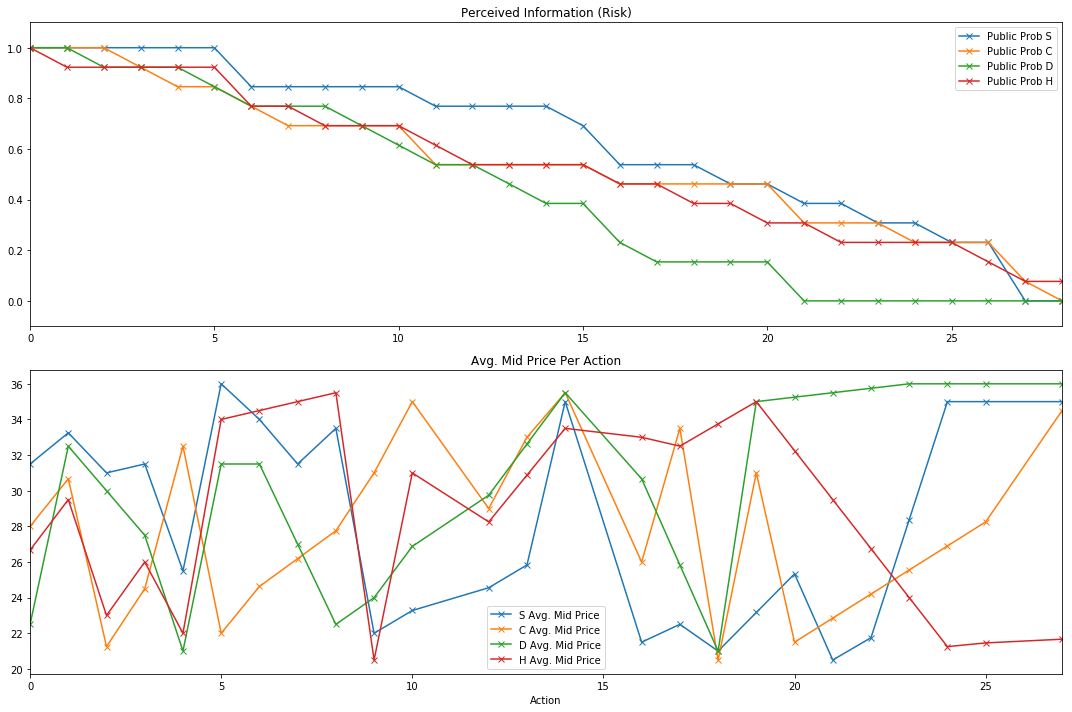

In [39]:
# todo 
# check why probability doesn't converge to 0 (try extend the x axis)
pb.viz()

In [40]:
# Player
# Once the trade is executed, register the trade on their own ledger
## information recorded
# Functionalities reveal private information
# Compute private and perceived probabilities
# generate insights
# plot risks

In [41]:
p1.ledger

,Action,CounterParty,Contract,Price,Quantity,Buy/Sell,S,C,D,H,Cash
1,0.0,H,H,-28,4,Buy,0,0,0,4,-112
5,0.4,H,H,-23,3,Buy,0,0,0,7,-181
7,0.6,H,H,-34,3,Buy,0,0,0,10,-283
8,0.7,D,S,-31,1,Buy,1,0,0,10,-314
11,1.1,C,S,33,3,Sell,-2,0,0,10,-215
13,1.3,H,H,-31,2,Buy,-2,0,0,12,-277
16,1.6,D,S,-34,3,Buy,1,0,0,12,-379
18,2.2,H,H,21,1,Sell,1,0,0,11,-358
19,2.3,C,S,-28,3,Buy,4,0,0,11,-442
20,2.4,D,S,-30,4,Buy,8,0,0,11,-562


In [20]:
p2.ledger

,Action,CounterParty,Contract,Price,Quantity,Buy/Sell,S,C,D,H,Cash
1,0.0,S,S,-28,2,Buy,2,0,0,0,-56
2,0.1,D,C,-25,4,Buy,2,4,0,0,-156
3,0.2,D,D,-34,4,Buy,2,4,4,0,-292
4,0.3,S,S,26,1,Sell,1,4,4,0,-266
5,0.4,H,H,21,1,Sell,1,4,4,-1,-245
6,0.5,S,C,-28,3,Buy,1,7,4,-1,-329
9,1.0,H,C,-31,4,Buy,1,11,4,-1,-453
11,1.2,D,D,30,3,Sell,1,11,1,-1,-363
13,1.4,S,C,26,3,Sell,1,8,1,-1,-285
15,1.6,S,C,26,4,Sell,1,4,1,-1,-181


In [21]:
p3.ledger

,Action,CounterParty,Contract,Price,Quantity,Buy/Sell,S,C,D,H,Cash
2,0.1,C,C,25,4,Sell,0,-4,0,0,100
3,0.2,C,D,34,4,Sell,0,-4,-4,0,236
7,0.6,S,S,22,2,Sell,-2,-4,-4,0,280
11,1.2,C,D,-30,3,Buy,-2,-4,-1,0,190
12,1.3,H,H,-33,2,Buy,-2,-4,-1,2,124
14,1.5,H,H,33,2,Sell,-2,-4,-1,0,190
16,1.7,C,D,-23,1,Buy,-2,-4,0,0,167
17,1.8,S,S,-23,2,Buy,0,-4,0,0,121
18,2.1,H,H,24,1,Sell,0,-4,0,-1,145
19,2.2,H,D,-23,4,Buy,0,-4,4,-1,53


In [22]:
p4.ledger

,Action,CounterParty,Contract,Price,Quantity,Buy/Sell,S,C,D,H,Cash
5,0.4,C,H,-21,1,Buy,0,0,0,1,-21
8,0.7,S,S,-25,2,Buy,2,0,0,1,-71
9,1.0,C,C,31,4,Sell,2,-4,0,1,53
10,1.1,S,H,34,3,Sell,2,-4,0,-2,155
12,1.3,D,H,33,2,Sell,2,-4,0,-4,221
14,1.5,D,H,-33,2,Buy,2,-4,0,-2,155
18,2.1,D,H,-24,1,Buy,2,-4,0,-1,131
19,2.2,D,D,23,4,Sell,2,-4,-4,-1,223
20,2.3,D,D,-34,4,Buy,2,-4,0,-1,87
22,2.6,S,H,29,3,Sell,2,-4,0,-4,174
